In [6]:
from __future__ import print_function
from __future__ import division
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pytesseract
import argparse

In [7]:
# ---image processing function
def plotimage(title,img,colormap):
    print("plot image :",title)
    plotting = plt.imshow(img, cmap=colormap)
    plt.show()

def resizeImage(img,scale):
    print("resize image")
    # resize image
    scale_ratio = scale
    height = int(img.shape[0] * scale_ratio)
    width = int(img.shape[1] * scale_ratio)
    img = cv2.resize(img, (width,height), interpolation=cv2.INTER_AREA)
    return img

def saveImage(name,image):
    path = '/Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output'
    cv2.imwrite(path+'/'+name, image)
    print('writing image in ',path)

def showHistogram(img):
    if img is None:
        print('Could not open or find the image')
    
    bgr_planes = cv2.split(img)
    histogram_size = 256
    histogram_range = (0,256)

    accumulate = False
    blue_hist = cv2.calcHist(bgr_planes, [0], None, [histogram_size], histogram_range, accumulate=accumulate)
    green_hist = cv2.calcHist(bgr_planes, [1], None, [histogram_size], histogram_range, accumulate=accumulate)
    red_hist = cv2.calcHist(bgr_planes, [2], None, [histogram_size], histogram_range, accumulate=accumulate)

    print('pass ---')

    display_w = 512
    display_h = 400
    bin_w = int(round(display_w/ histogram_size))
    histograme_image = np.zeros((display_h, display_w,3), dtype=np.uint8)

    cv2.normalize(blue_hist, blue_hist, alpha=0, beta=display_h, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(green_hist, green_hist, alpha=0, beta=display_h, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(red_hist, red_hist, alpha=0, beta=display_h, norm_type=cv2.NORM_MINMAX)

    for i in range(1, histogram_size):
        cv2.line(histograme_image, ( bin_w*(i-1), display_h - int(np.round(blue_hist[i-1])) ),
            ( bin_w*(i), display_h - int(np.round(blue_hist[i])) ),
            ( 255, 0, 0), thickness=2)
        cv2.line(histograme_image, ( bin_w*(i-1), display_h - int(np.round(green_hist[i-1])) ),
            ( bin_w*(i), display_h - int(np.round(green_hist[i])) ),
            ( 0, 255, 0), thickness=2)
        cv2.line(histograme_image, ( bin_w*(i-1), display_h - int(np.round(red_hist[i-1])) ),
            ( bin_w*(i), display_h - int(np.round(red_hist[i])) ),
            ( 0, 0, 255), thickness=2)

    # cv2.imshow('histograme',histograme_image)
    # cv2.waitKey(0)
    plotimage('histogram image',histograme_image,'jet')


plot image : img Q


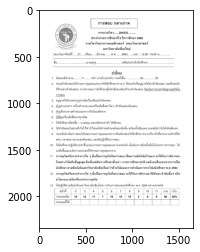

pass ---
plot image : histogram image


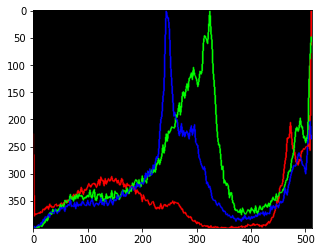

In [8]:
# ---import image
imgQ = cv2.imread('../image/midterm-score/midterm-score.jpg',0)
imgtest = cv2.imread('../image/hist_test.jpg')
plotimage('img Q',imgQ, 'gray')
showHistogram(imgtest)


plot image : imgQ keypoint


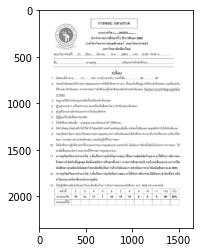

In [9]:
# -- warp Image
# ---faeture of query image
orb = cv2.ORB_create()
orb = cv2.ORB_create(nfeatures=1000)
kp1, des1 = orb.detectAndCompute(imgQ, None)
imgKp1 = cv2.drawKeypoints(imgQ,kp1,None)

plotimage('imgQ keypoint',imgKp1, 'gray')

plot image : img form


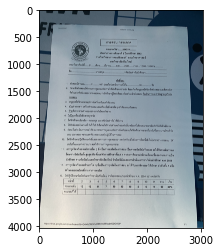

In [10]:
# ---import user forms
img = cv2.imread('../image/userForms-image/test6.JPG')
plotimage('img form', img, 'gray')

plot image : img matching


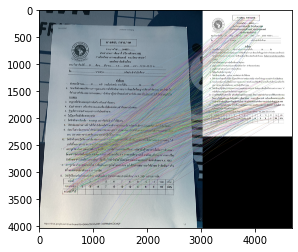

In [11]:
# ---find the feature
kp2, des2 = orb.detectAndCompute(img, None)

# ---Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.match(des2, des1)

# ---Right after matching we will sort out the best matches and store them in a list by the name good. Let’s have a look at one of these matches.
persen = 50
matches.sort(key = lambda x:x.distance)
good = matches[:int(len(matches) * (persen/100))]
imgMatches = cv2.drawMatches(img, kp2, imgQ, kp1, good, None, flags=2)

plotimage('img matching',imgMatches, 'gray')

finish scan !!!
plot image : img scan


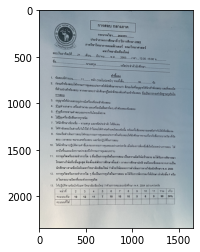

In [12]:
# --- scan or wrap
# --- Aligning The Forms Since the our user forms are not in the correct alignment, we cannot extract the text information yet. So we will first align these images using the key points from both our images.
# --- Given we have a few points in our user form and the location of same points in the query image we can find the relationship between them. This relationship is basically a matrix, and the process of finding it is know as Homography. Using this relationship we can align our user form.

srcPts = np.float32([kp2[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dstPts = np.float32([kp1[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
M, _ = cv2.findHomography(srcPts, dstPts, cv2.RANSAC, 5.0)

h, w = imgQ.shape[:2]
imgScan = cv2.warpPerspective(img, M, (w, h))

print('finish scan !!!')
plotimage('img scan', imgScan, 'gray')

plot image : img roi


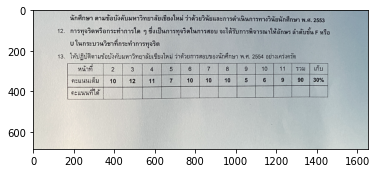

In [13]:
img = imgScan

x, y, channel = img.shape

# roi
img = img[y:,:]
plotimage('img roi', img, 'gray')

plot image : gray image


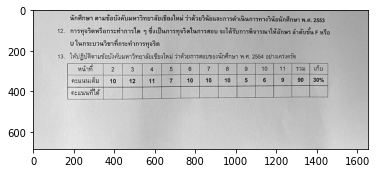

plot image : threshold


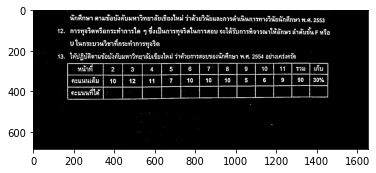

plot image : image vertical line


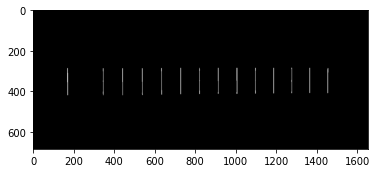

writing image in  /Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output
plot image : image horizontal line


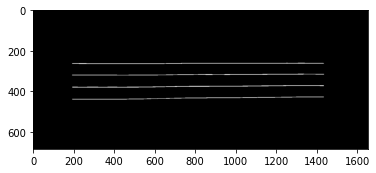

writing image in  /Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output
writing image in  /Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/output
plot image : image vertival and horizontal line


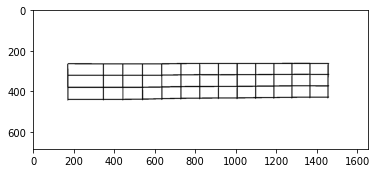

plot image : bitnor


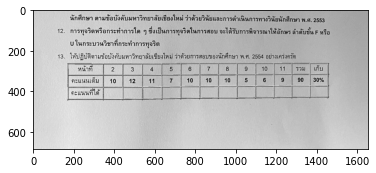

In [14]:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plotimage('gray image', gray_img, 'gray')


#blur
blur = cv2.GaussianBlur(gray_img,(5,5),0)
#thresholding
thresh = cv2.adaptiveThreshold(blur,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,35,10)
plotimage('threshold', thresh, 'gray')

# Length(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100

# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(thresh, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
plotimage('image vertical line', image_1, 'gray')
saveImage('vertical_line.jpg', image_1)

#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(thresh, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
plotimage('image horizontal line', image_2, 'gray')
saveImage('horizontal_line.jpg', image_2)

# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
saveImage('vh_line.jpg', img_vh)

#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plotimage('image vertival and horizontal line', img_vh, 'gray')


bitxor = cv2.bitwise_xor(gray_img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
plotimage('bitnor', bitnot, 'gray')

plot image : mask


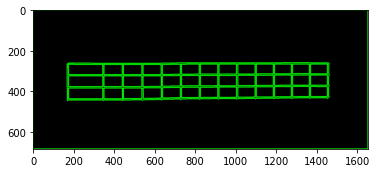

plot image : box 0


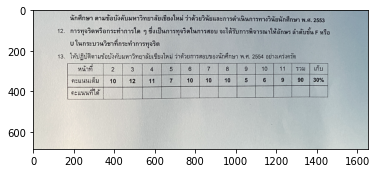

plot image : box 1


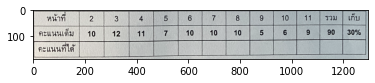

plot image : box 2


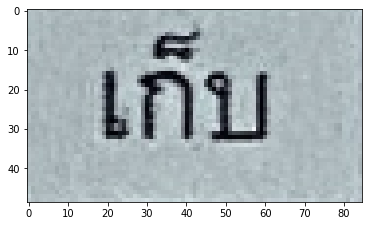

plot image : box 3


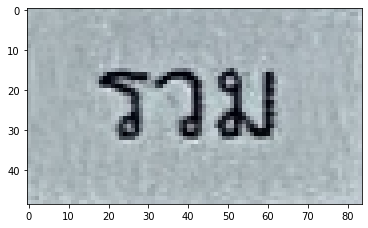

plot image : box 4


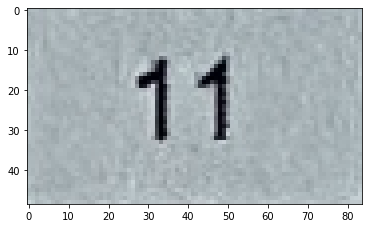

plot image : box 5


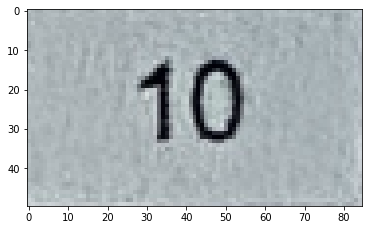

plot image : box 6


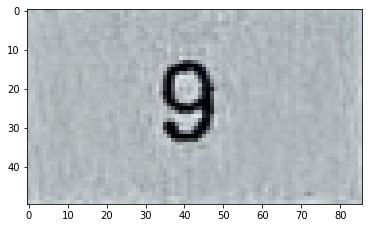

plot image : box 7


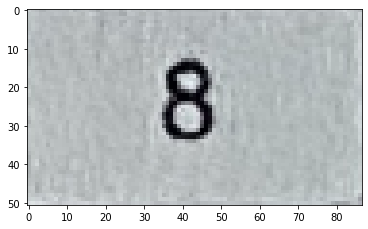

plot image : box 8


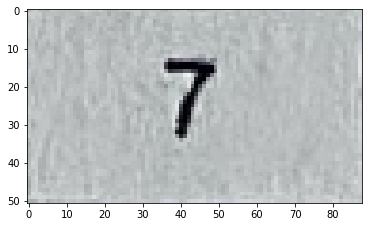

plot image : box 9


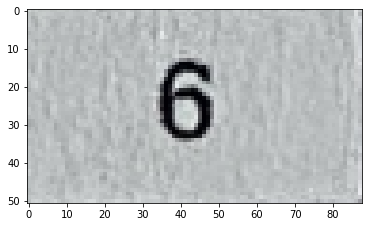

plot image : box 10


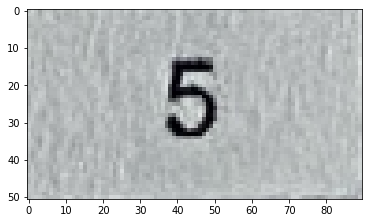

plot image : box 11


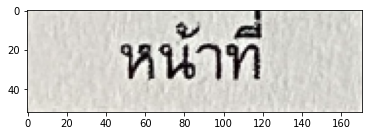

plot image : box 12


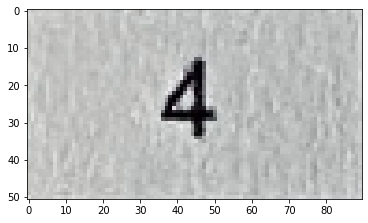

plot image : box 13


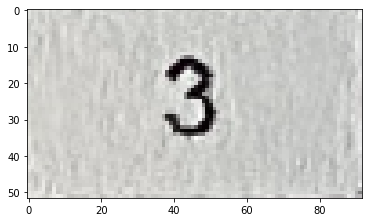

plot image : box 14


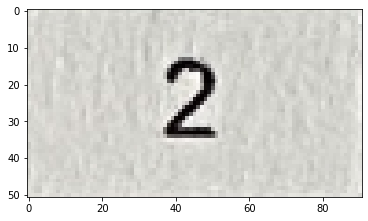

plot image : box 15


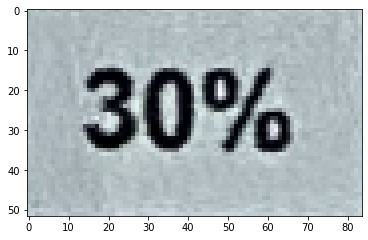

plot image : box 16


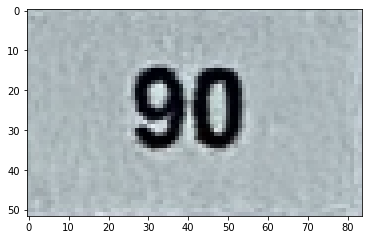

plot image : box 17


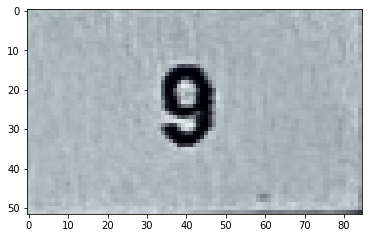

plot image : box 18


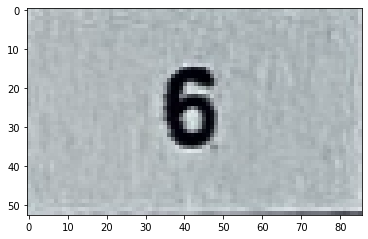

plot image : box 19


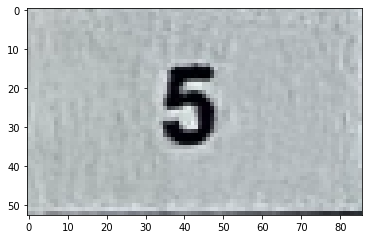

plot image : box 20


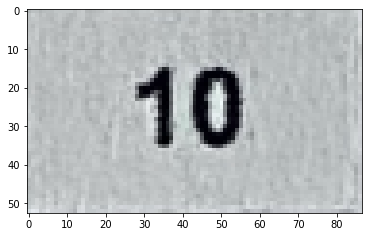

plot image : box 21


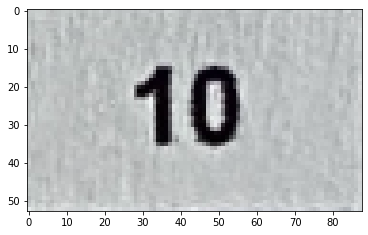

plot image : box 22


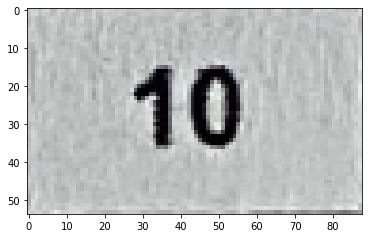

plot image : box 23


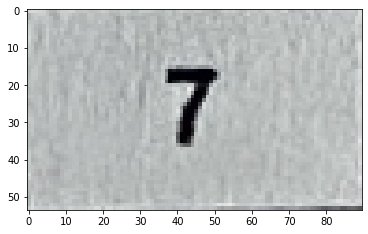

plot image : box 24


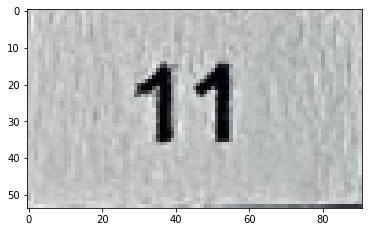

plot image : box 25


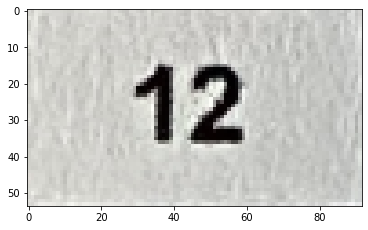

plot image : box 26


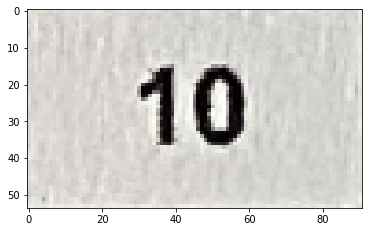

plot image : box 27


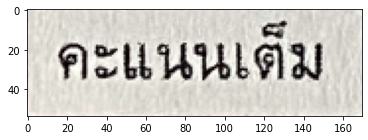

plot image : box 28


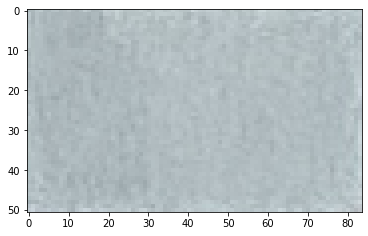

plot image : box 29


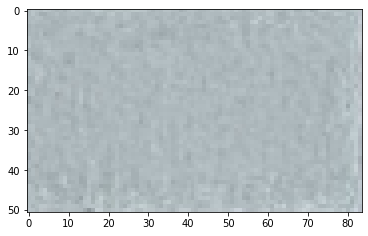

plot image : box 30


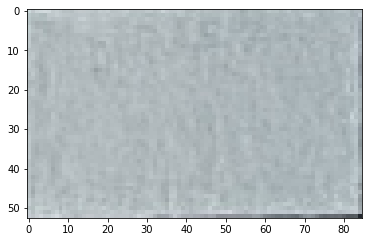

plot image : box 31


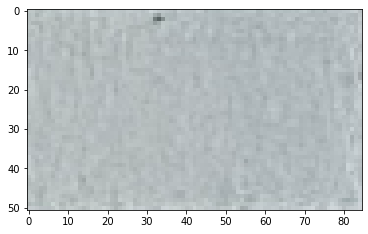

plot image : box 32


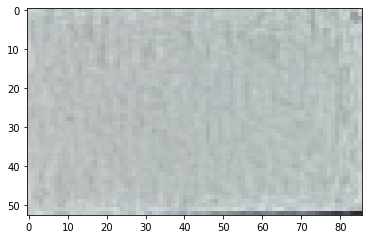

plot image : box 33


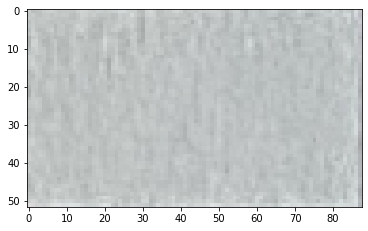

plot image : box 34


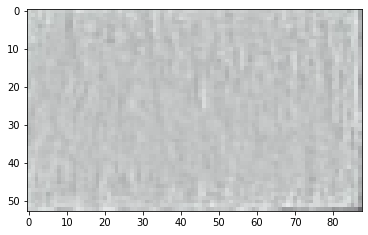

plot image : box 35


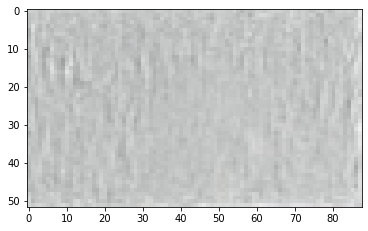

plot image : box 36


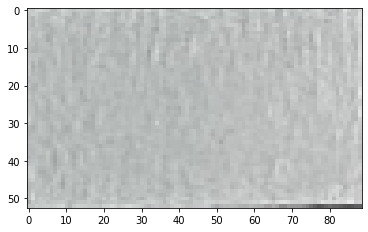

plot image : box 37


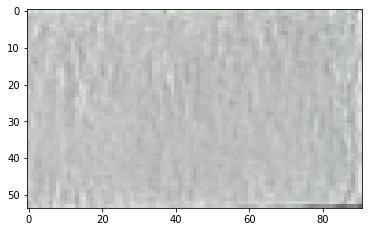

plot image : box 38


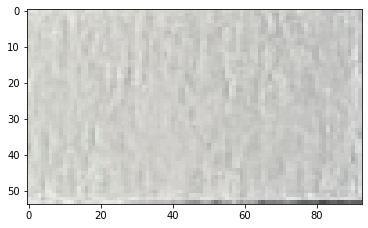

plot image : box 39


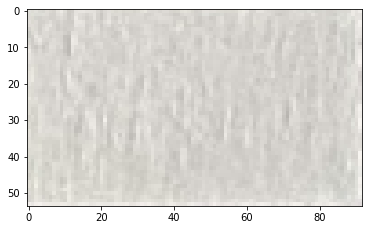

plot image : box 40


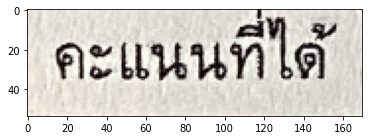

plot image : image contours


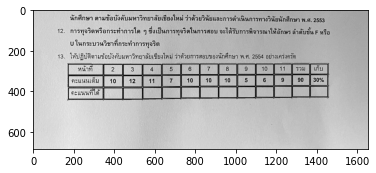

In [49]:
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros(img.shape, dtype=np.uint8)
cv2.drawContours(mask, contours, -1, (0, 255, 0), 3)
plotimage('mask',mask, 'gray')

# sort contours
# initialize the reverse flag and sort index
reverse = False
i = 1
# construct the list of bounding boxes and sort them from top to
# bottom
boundingBoxes = [cv2.boundingRect(c) for c in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b:b[1][i], reverse=reverse))

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in 
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i])

    if (w<1000 and h<500):
        image = cv2.rectangle(bitnot,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])

    b = img[y:y+h, x:x+w]
    title_box = 'box '+ str(i)
    plotimage(title_box, b, 'gray')


plotimage('image contours',image, 'gray')